# Mini-Project OCR Code

This is a walkthrough of the process we went through to develop an OCR model that recognizes handwriting.

Our libraries used are listed in the README, we will utilize requirements.txt to load them all at once.

**IMPORTANT** Make sure to use `python3.6` (the version we use for class projects) to run our program with little issues. Information can be found [here](https://courses.cs.vt.edu/cs4804/Spring24/projects/project0.html#python-installation) 

In [ ]:
# Install libraries
%pip install -r requirements.txt

In [149]:
# Load libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras

from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

## Helper functions for loading dataset

We need to load our dataset. We will create a helper function for the model OCR. This function will load the English Handwritten Characters dataset that should be in given path.

In [2]:
def load_eng_dataset(datasetPath):
	 # initialize the list of data and labels
    data = []
    labels = []

    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(datasetPath):
        # Skip the first row
        if row == "image,label\n":
            continue

        # parse the label and image from the row
        row = row.split(",")
        imagePath = "eng_dataset/" + row[0] # hardcode the path
        try:
            image = cv2.imread(imagePath)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        except cv2.error as e:
            print("[ERROR] loading image ", row[0], " fail")
            continue
        
        label = row[1][:-1] if len(row[1]) > 1 else row[1] # remove '\n' at end

        # update the list of data and labels
        data.append(image)
        labels.append(label)

    # convert the data and labels to NumPy arrays
    data = np.array(data)
    labels = np.array(labels, dtype="U1")
	# return a 2-tuple of the English Handwritten Characters data and labels
    return (data, labels)

### Dataset Pre-Processing

Next we will pre-process the dataset in order to train the model.

In [3]:
def process_dataset(data, labels):
    """
    Help function to pre-process the dataset for ready to train model.
    """
    # the architecture we're using is designed for 32x32 images,
    # so we need to resize them to 32x32
    data = [cv2.resize(image, (32, 32)) for image in data]
    data = np.array(data, dtype="float32")

    # add a channel dimension to every image in the dataset and 
    # data = np.expand_dims(data, axis=-1)

    # scale the pixel intensities of the images from [0, 255] down to [0, 1]
    data /= 255.0

    # convert the labels from integers to vectors
    le = LabelBinarizer()
    labels = le.fit_transform(labels)

    # account for skew in the labeled data
    classTotals = labels.sum(axis=0)
    classWeight = {}
    # loop over all classes and calculate the class weight
    for i in range(0, len(classTotals)):
        classWeight[i] = classTotals.max() / classTotals[i]

    return data, labels, classWeight

### Verification

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

We define the helper function here:

In [4]:
def show_train_data(train_images, train_labels):
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                   'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'G', 'K', 'L', 'M', 
                   'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
                   'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'g', 'k', 'l', 'm', 
                   'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i])
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        index = np.where(train_labels[i] == 1)[0][0]
        plt.xlabel(class_names[index])
    plt.show()

## Load and Pre-Process

First, we need to load and pre-process the data. We will use the functions we defined previously.

Make sure the English Handwritten Characters dataset is loocated in `/eng_dataset` in the following format:

```
.
├── ocr_project.ipynb
└── eng_dataset
    ├── english.csv
    └── Img
        ├── imgXXX-XXX.png
        └── ...
```


In [5]:
# Define directories here
datasetPath = "eng_dataset/english.csv"

In [6]:
# load the English Handwritten Characters datasets
print("[INFO] loading datasets...")
(data, labels) = load_eng_dataset(datasetPath)

# pre-process the data and labels for training
print("[INFO] pre-processing datasets...")
data, labels, classWeight = process_dataset(data, labels)

[INFO] loading datasets...
[INFO] pre-processing datasets...


## Training

Time to begin the training, we need to split the data for training and testing first. The training data will be shown here.

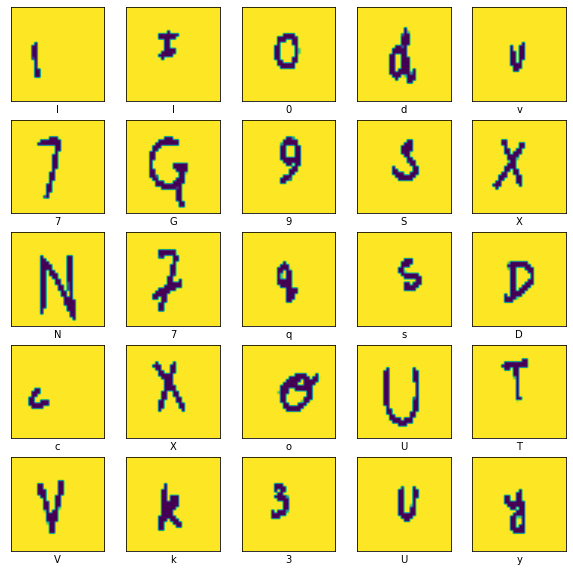

'Training image Shape: (3069, 32, 32)'

'Testing image Shape: (341, 32, 32)'

In [165]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
(train_images, test_images, train_labels, test_labels) = train_test_split(data,
        labels, test_size=0.10, stratify=labels, random_state=42)
    
# show train data in plot
show_train_data(train_images, train_labels)

# Show shapes
display(f"Training image Shape: {train_images.shape}")
display(f"Testing image Shape: {test_images.shape}")

Looks great!

### Modeling

We need to define some parameters for our model. Here is what they mean:

- `EPOCHS` - amount of iterations to fit the model
- `BATCH_SIZE` - size of slices of the dataset

Info about model

In [10]:
EPOCHS = 80
BATCH_SIZE = 50

In [135]:
# initialize and compile our deep neural network
print("[INFO] compiling model...")
model = models.Sequential([keras.Input(shape=(32, 32, 1))])
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(62, activation='softmax'))

[INFO] compiling model...


In [136]:
# Use categorical_crossentropy for one-hot coding labels
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

display(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_23 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)              

None

Since we are using a CNN, we need to add the channel parameter to our training and test data shapes. This is so our data is represented as `(batch_size, new_height, new_width, filters)`.

In [137]:
# Keras needs a channel dimension for the model
# Since the images are greyscale, the channel can be 1
train_images = train_images.reshape(-1, 32, 32, 1)
test_images = test_images.reshape(-1, 32, 32, 1)
display(test_images.shape)

(341, 32, 32, 1)

In [138]:

# train the network
print("[INFO] training model...")
history = model.fit(x=train_images, 
                    y=train_labels, 
                    validation_data=(test_images, test_labels), 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    class_weight=classWeight)

[INFO] training model...
Epoch 1/80
62/62 [==============================] - 3s 27ms/step - loss: 4.1115 - accuracy: 0.0257 - val_loss: 4.0033 - val_accuracy: 0.0557
Epoch 2/80
62/62 [==============================] - 1s 22ms/step - loss: 3.4961 - accuracy: 0.1310 - val_loss: 3.1457 - val_accuracy: 0.2082
Epoch 3/80
62/62 [==============================] - 1s 22ms/step - loss: 2.4779 - accuracy: 0.3506 - val_loss: 2.2735 - val_accuracy: 0.3930
Epoch 4/80
62/62 [==============================] - 1s 21ms/step - loss: 1.8061 - accuracy: 0.5122 - val_loss: 1.8761 - val_accuracy: 0.4663
Epoch 5/80
62/62 [==============================] - 1s 20ms/step - loss: 1.4414 - accuracy: 0.6002 - val_loss: 1.5583 - val_accuracy: 0.5689
Epoch 6/80
62/62 [==============================] - 1s 19ms/step - loss: 1.1454 - accuracy: 0.6693 - val_loss: 1.3188 - val_accuracy: 0.6334
Epoch 7/80
62/62 [==============================] - 1s 23ms/step - loss: 0.9367 - accuracy: 0.7247 - val_loss: 1.2408 - val_accur

In [168]:
acc_per_fold = []
loss_per_fold = []
kf = KFold(n_splits=10, random_state=42, shuffle=True)
fold = 1
for train_index, test_index in kf.split(data, labels):
    model = models.Sequential([keras.Input(shape=(32, 32, 1))])
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(62, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold} ...')
    
    train_images, test_images  = data[train_index], data[test_index]
    train_labels, test_labels =  labels[train_index], labels[test_index]

    train_images = train_images.reshape(-1, 32, 32, 1)
    test_images = test_images.reshape(-1, 32, 32, 1)

    history = model.fit(x=train_images, 
                    y=train_labels, 
                    validation_data=(test_images, test_labels), 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    class_weight=classWeight)
    
      # Generate generalization metrics
    scores = model.evaluate(test_images, test_labels, verbose=0)
    print(f'Score for fold {fold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold+=1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/80
62/62 [==============================] - 3s 30ms/step - loss: 4.1090 - accuracy: 0.0283 - val_loss: 3.9846 - val_accuracy: 0.0616
Epoch 2/80
62/62 [==============================] - 2s 25ms/step - loss: 3.4496 - accuracy: 0.1466 - val_loss: 3.0225 - val_accuracy: 0.2199
Epoch 3/80
62/62 [==============================] - 1s 20ms/step - loss: 2.6281 - accuracy: 0.3073 - val_loss: 2.5281 - val_accuracy: 0.3548
Epoch 4/80
62/62 [==============================] - 1s 23ms/step - loss: 2.0361 - accuracy: 0.4630 - val_loss: 2.1338 - val_accuracy: 0.4252
Epoch 5/80
62/62 [==============================] - 1s 21ms/step - loss: 1.5790 - accuracy: 0.5666 - val_loss: 1.8311 - val_accuracy: 0.5279
Epoch 6/80
62/62 [==============================] - 1s 23ms/step - loss: 1.2539 - accuracy: 0.6383 - val_loss: 1.5830 - val_accuracy: 0.5777
Epoch 7/80
62/62 [==============================] - 1s 21

In [169]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.8269495964050293 - Accuracy: 63.63636255264282%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9607480764389038 - Accuracy: 68.62170100212097%
------------------------------------------------------------------------
> Fold 3 - Loss: 2.3371033668518066 - Accuracy: 70.3812301158905%
------------------------------------------------------------------------
> Fold 4 - Loss: 2.010115623474121 - Accuracy: 69.79472041130066%
------------------------------------------------------------------------
> Fold 5 - Loss: 2.6227874755859375 - Accuracy: 72.14076519012451%
------------------------------------------------------------------------
> Fold 6 - Loss: 2.587796926498413 - Accuracy: 68.62170100212097%
------------------------------------------------------------------------
> 

## Validation

Now, we need to validate our data. Using the test data we split earlier, we can evaluate our  model. Let's plot our training accuracy.

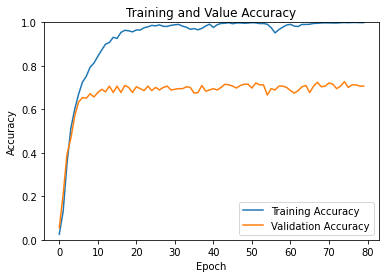

In [139]:
# Plot accuracies
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Training and Value Accuracy")
plt.savefig("accuracy_plot")
plt.show()

A big difference between training accuracy and validation accuracy means we could have potentially overfitted the model.

### Evaluation

We can evaluate the loss and accuracy with the `evaluate` function

In [146]:
# evaluate the network

print("[INFO] evaluating network...")
testmodel = load_model("./model.keras")
results = testmodel.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)
display(f"test loss, test acc:", results)

[INFO] evaluating network...
7/7 [==============================] - 0s 12ms/step - loss: 2.5202 - accuracy: 0.7097


'test loss, test acc:'

[2.520172357559204, 0.7096773982048035]

### Predictions

Let's predict with our model.

In [147]:
print("[INFO] predicting test samples...")
predictions = testmodel.predict(test_images, batch_size=BATCH_SIZE)
display("predictions shape:", predictions.shape)

# labels for readability
labelNames = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                   'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'G', 'K', 'L', 'M', 
                   'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
                   'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'g', 'k', 'l', 'm', 
                   'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

print(classification_report(test_labels.argmax(axis=1),
    predictions.argmax(axis=1), target_names=labelNames))

[INFO] predicting test samples...


'predictions shape:'

(341, 62)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.75      0.50      0.60         6
           2       0.67      0.80      0.73         5
           3       1.00      0.80      0.89         5
           4       1.00      0.40      0.57         5
           5       0.75      0.60      0.67         5
           6       0.71      0.83      0.77         6
           7       0.80      0.80      0.80         5
           8       0.50      0.60      0.55         5
           9       1.00      0.60      0.75         5
           A       0.80      0.67      0.73         6
           B       0.60      0.60      0.60         5
           C       0.67      0.67      0.67         6
           D       0.83      1.00      0.91         5
           E       1.00      0.60      0.75         5
           F       0.83      0.83      0.83         6
           G       1.00      0.80      0.89         5
           H       0.83    

## Saving

Lets save the model.

In [98]:
 # save the model to disk
print("[INFO] saving trained model...")
model.save("OCR_CNN.h5")

[INFO] saving trained model...
